# CS597 Deep Learning - Assignment 6
## Keras Transfer Learning: Santa Claus Detector

In this assignment, you will use a pre-trained convnet to produce features for a classifier that can detect Santa Claus. This notebook has some code to help you get started. You should also have a `pos.tx` file and a `neg.txt` file. 



* I followed [this](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/) to generate the pos.txt and neg.txt files from Google Images
* make sure you have a `pos_images` folder and a `neg_images` folder in the same directory as this notebook

In [1]:
import random
random.seed(42)

from imutils import paths
import requests
import cv2
import os
from os import listdir
from os.path import isfile, join

In [2]:
pos_urls = 'pos.txt'
neg_urls = 'neg.txt'
pos_output = 'pos_images'
neg_output = 'neg_images'

# grab the list of URLs from each folder
pos_rows = open(pos_urls).read().strip().split("\n")
neg_rows = open(neg_urls).read().strip().split("\n")

len(pos_rows), len(neg_rows)

(100, 200)

### 1.) Getting the images

* It should download lots of images into the `*_images` folders using the `pos.txt` and `neg.txt` files.
* Have a look in the two images folders and see what the images are. 
  * `pos_images` should have images of Santa Claus
  * `neg_images` should have a bunch of random images of other things
  * These images constitute the positive and negative training examples for your Santa Claus classifier
  * If you want to change the target (i.e., something besides Santa Claus), generate your own urls.txt file using [this](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)
tutorial
* note that some of the images might not download properly, you'll need to handle those somehow (either throw them out or ignore them)

Run the next two cells. 

In [3]:
# Comment out this cell so run-all works without having to redownload everything.
'''
def download_images(rows, output):
    total = 0
    for url in rows:
        try:
            # try to download the image
            r = requests.get(url, timeout=60)
            # save the image to disk
            p = os.path.sep.join((output, "{}.jpg".format(
                str(total).zfill(8))))
            f = open(p, "wb")
            f.write(r.content)
            f.close()

            # update the counter
            total += 1
       # handle if any exceptions are thrown during the download process
        except:
            print("[INFO] error downloading {}...skipping")
    
download_images(pos_rows, pos_output)
download_images(neg_rows, neg_output)
'''

'\ndef download_images(rows, output):\n    total = 0\n    for url in rows:\n        try:\n            # try to download the image\n            r = requests.get(url, timeout=60)\n            # save the image to disk\n            p = os.path.sep.join((output, "{}.jpg".format(\n                str(total).zfill(8))))\n            f = open(p, "wb")\n            f.write(r.content)\n            f.close()\n\n            # update the counter\n            total += 1\n       # handle if any exceptions are thrown during the download process\n        except:\n            print("[INFO] error downloading {}...skipping")\n    \ndownload_images(pos_rows, pos_output)\ndownload_images(neg_rows, neg_output)\n'

In [4]:
# load the image file names, keep them handy
pos_image_files = [f for f in listdir(pos_output) if isfile(join(neg_output, f))]
neg_image_files = [f for f in listdir(pos_output) if isfile(join(neg_output, f))]

## 2.) Run the following cell

* This imports needed Keras libraries
* Then, it gets the trained VGG19 imagenet model
* Then, it prints out the names of all the layers in that model

In [5]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import numpy as np

base_model = VGG19(weights='imagenet')

for layer in base_model.layers:
    print('name: ' + layer.name + ", shape: " + str(layer.output.shape))

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


name: input_1, shape: (?, 224, 224, 3)
name: block1_conv1, shape: (?, 224, 224, 64)
name: block1_conv2, shape: (?, 224, 224, 64)
name: block1_pool, shape: (?, 112, 112, 64)
name: block2_conv1, shape: (?, 112, 112, 128)
name: block2_conv2, shape: (?, 112, 112, 128)
name: block2_pool, shape: (?, 56, 56, 128)
name: block3_conv1, shape: (?, 56, 56, 256)
name: block3_conv2, shape: (?, 56, 56, 256)
name: block3_conv3, shape: (?, 56, 56, 256)
name: block3_conv4, shape: (?, 56, 56, 256)
name: block3_pool, shape: (?, 28, 28, 256)
name: block4_conv1, shape: (?, 28, 28, 512)
name: block4_conv2, shape: (?, 28, 28, 512)
name: block4_conv3, shape: (?, 28, 28, 512)
name: block4_conv4, shape: (?, 28, 28, 512)
name: block4_pool, shape: (?, 14, 14, 512)
name: block5_conv1, shape: (?, 14, 14, 512)
name: block5_conv2, shape: (?, 14, 14, 512)
name: block5_conv3, shape: (?, 14, 14, 512)
name: block5_conv4, shape: (?, 14, 14, 512)
name: block5_pool, shape: (?, 7, 7, 512)
name: flatten, shape: (?, ?)
name: fc

## 3.) Write a Santa Claus classifier

* Use `base_model` to obtain image features. You will need to pass the images from the `pos_images` folder and the `neg_images` folder to the `base_model` to obtain the features. Use the top `predictions` layer to obtain the features. 
* Hint: there is a notebook from the Keras lecture that will be helpful 
* Using the positive and negative output from `base_model`, train a classifier (it can be a linear classifier from scikit-learn, if you'd like). 
* You'll need to split your data into Train and Test (I would recommend using half of the data for training, half for testing; you may opt for downloading more positive and negative examples)

In [6]:
def get_image_preprocessor(folder, target_shape):
    # I read online that the images need to have pixel values normalized
    datagen = image.ImageDataGenerator(rescale = 1./255)
    #datagen = image.ImageDataGenerator()
    return datagen.flow_from_directory(folder,
                                       target_size = target_shape,
                                       class_mode = None,
                                       batch_size = 16)

In [7]:
def get_X_y(target_shape):
    X_bat = get_image_preprocessor('.', target_shape)
    X = None
    idx = 0
    for X_bat_cur in X_bat:
        if X is None:
            X = np.zeros(shape = (X_bat.samples, X_bat_cur.shape[1], X_bat_cur.shape[2], X_bat_cur.shape[3]))
        X[idx : idx + X_bat_cur.shape[0]] = X_bat_cur
        idx += X_bat_cur.shape[0]
        if idx >= X_bat.samples:
            break
    # Classes returned by the image preprocessor were 1 for negative, 2 for positive.
    num_pos = 0
    num_neg = 0
    y = []
    for cur_class in X_bat.classes:
        if cur_class == 2:
            num_pos += 1
            y += [1.0]
        else:
            num_neg += 1
            y += [0.0]
    y = np.array(y)
    return (X, y, num_pos, num_neg)

In [8]:
# VGG19 preferred size is 224x224
X, y, num_pos, num_neg = get_X_y((224, 224))

Found 287 images belonging to 3 classes.


/usr/lib/python3.6/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [9]:
from sklearn import model_selection as ms
from sklearn import linear_model as lm
import matplotlib.pylab as plt

def test_model(transfer_model, X, y):
    X_prime = transfer_model.predict(X)

    shuffle_split = ms.ShuffleSplit(n_splits = 1, test_size = 0.5, random_state = 42)
    X_prime_tr, y_tr, X_prime_te, y_te = (None, None, None, None)
    for train_idx, test_idx in shuffle_split.split(X_prime):
        X_prime_tr = X_prime[train_idx]
        y_tr = y[train_idx]
        X_prime_te = X_prime[test_idx]
        y_te = y[test_idx]
    
    my_model = lm.LogisticRegression(random_state = 42)
    my_model.fit(X_prime_tr, y_tr)
    print(my_model.score(X_prime_te, y_te))
    
    _, class_counts = np.unique(y_tr, return_counts = True)
    lesser_class_count = np.min(class_counts)

    num_samples = []
    accur = []
    for i in range(lesser_class_count):
        num_pos_cur = 0
        num_neg_cur = 0
        X_prime_tr_small = []
        y_tr_small = []
        # Since X_prime_tr is shuffled, we must do some logic to ensure we take an equal number of both classes.
        for X_prime_tr_cur, y_tr_cur in zip(X_prime_tr, y_tr):
            if num_neg_cur == lesser_class_count and num_pos_cur == lesser_class_count:
                break

            if y_tr_cur == 0.0 and num_neg_cur < i + 1:
                num_neg_cur += 1
            elif y_tr_cur == 1.0 and num_pos_cur < i + 1:
                num_pos_cur += 1
            else:
                continue
            X_prime_tr_small += [X_prime_tr_cur]
            y_tr_small += [y_tr_cur]

        X_prime_tr_small = np.array(X_prime_tr_small)
        y_tr_small = np.array(y_tr_small)

        my_model = lm.LogisticRegression(random_state = 42)
        my_model.fit(X_prime_tr_small, y_tr_small)
        num_samples += [i + 1]
        accur += [my_model.score(X_prime_te, y_te)]

    plt.plot(num_samples, accur)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.show()

## 4.) Analyze and Compare Layers

* Generate a plot where the `x` axis represents the number of training examples used to train your Santa Claus classifier and the `y` axis is the accuracy on your training data (range from 10 training examples--5 positive, 5 negative--and increment by one more pos/neg training example until you've used all your training data). You should see accuracy go up as the number of training examples increases. 
* Repeat step 3 above using a different layer from the Keras VGG19 `base_model` (e.g., `flatten`). How well does your Santa Claus classifier work when comparing the two different layers?


0.6736111111111112


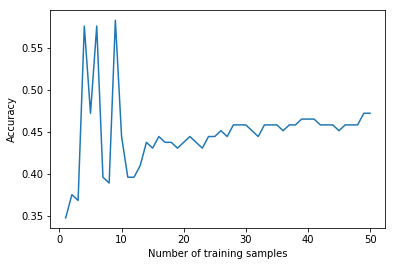

In [10]:
test_model(base_model, X, y)

0.6319444444444444


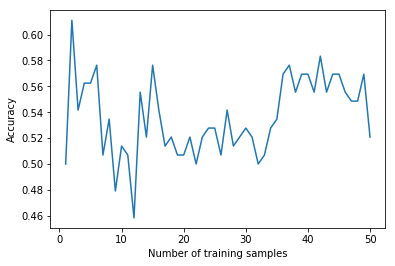

In [11]:
test_model(Model(inputs = base_model.inputs,
                 outputs = base_model.layers[-4].output),
           X,
           y)

## 5.) Try a Different `base_model` 

* Repeat steps 3 and 4 above, only this time use a [pre-trained model other than VGG19](https://keras.io/applications/)
* When you are done, you should have 4 plots: two for VGG19 and two for another model of your choice. Each should have a comparison of two layers. 
* (Answer in a markdown cell): Which model+layer works the best for this data? Why do you think that is?

0.6666666666666666


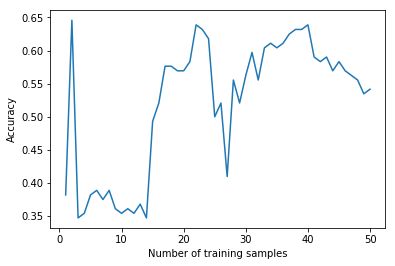

In [12]:
from keras.applications.xception import Xception

base_model = Xception(weights = 'imagenet')
test_model(base_model, X, y)

0.6180555555555556


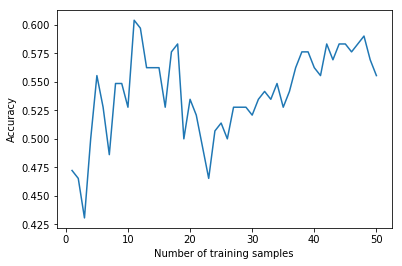

In [13]:
# -2 is the avg_pool layer.
test_model(Model(inputs = base_model.inputs,
                 outputs = base_model.layers[-2].output),
           X,
           y)